# Network Science (HS21)
## Assignment 6

### Ben     Murphy          16-714-925
### Florian Rüegsegger      14-714-737

#### The excercise was solved together in person



In [7]:
import os
import networkx as nx
import re
from networkx import read_graphml
from NEMtropy import UndirectedGraph, DirectedGraph
from NEMtropy.network_functions import build_adjacency_from_edgelist
import numpy as np
from typing import Dict
import matplotlib.pyplot as plt
from networkx import degree_pearson_correlation_coefficient

# A06.1

In [13]:
def fit_and_sample_cm(graph: nx.Graph,cm_class, model, name: str):
    adj_matrix = nx.to_numpy_array(graph)
    graph = cm_class(adj_matrix)
    graph.solve_tool(model=model)
    graph.ensemble_sampler(10,cpu_n=1, output_dir=f"samples/{graph.__class__.__name__}/{name}/")


def get_data(graph: nx.Graph, name: str, skip_sampling):
    if not skip_sampling:
        fit_and_sample_cm(graph, UndirectedGraph,"cm_exp",name)
        fit_and_sample_cm(graph, DirectedGraph,"dcm_exp", name)
    clusterings = []
    reciprocities = []
    for i in range(10):
        edgelist = np.loadtxt(f"samples/DirectedGraph/{name}/{i}.txt")
        net = nx.DiGraph()
        net.add_edges_from(edgelist)
        
        clusterings.append(nx.average_clustering(net))
        reciprocities.append(nx.reciprocity(net))

    return np.mean(clusterings), np.mean(reciprocities)


def plot_data(x,y,label):
    plt.plot(x, y, label=label)

def solve01(graphs: Dict,skip_sampling=False):
    clusters_og = []
    recip_og = []
    clusters_model = []
    recip_model = []
    
    keys = sorted([key for key in graphs.keys()])
    for key in keys:
        print(f"{key}")
        clusters_og.append(nx.average_clustering(graphs[key]))
        recip_og.append(nx.reciprocity(graphs[key]))

        data = get_data(graphs[key], key, skip_sampling)
        clusters_model.append(data[0])
        recip_model.append(data[1])
    
    plot_data(keys, clusters_og, "clusters_og")
    plot_data(keys, clusters_model, "clusters_model")
    plot_data(keys, recip_og, "recip_og")
    plot_data(keys, recip_model, "recip_model")
    plt.legend()
    plt.show()



In [2]:
data_paths = os.listdir('data/')
data = {}
regex = re.compile(r'\d+')
for data_path in data_paths:
    year = regex.findall(data_path)
    data[int(year[0])] = read_graphml('data/' + data_path)

1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002


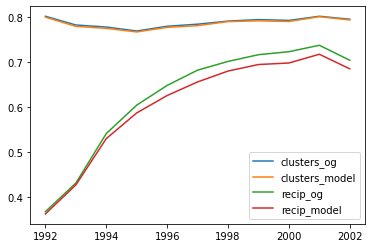

In [51]:
solve01(data,skip_sampling=False)

# A06.2

In [34]:
def fit_and_sample_crema(graph: nx.Graph,cm_class, adjaceny, name: str):
    adj_matrix = nx.to_numpy_array(graph)
    graph = cm_class(adj_matrix)
    graph.solve_tool(
        model="crema",
        method="newton",
        initial_guess="random",
        adjacency=adjaceny,
        method_adjacency="newton"
    )
    graph.ensemble_sampler(10,cpu_n=1, output_dir=f"samples/crema/{graph.__class__.__name__}/{name}/")


def get_data_weight(graph: nx.Graph, name: str, skip_sampling):
    if not skip_sampling:
        fit_and_sample_crema(graph, UndirectedGraph,"cm_exp",name)
        fit_and_sample_crema(graph, DirectedGraph,"dcm_exp", name)
    assortativities_directed = []
    assortativities_undirected = []

    for i in range(10):
        edgelist = np.loadtxt(f"samples/crema/DirectedGraph/{name}/{i}.txt")
        net = nx.DiGraph()
        net.add_weighted_edges_from(edgelist)
        assortativities_directed.append(degree_pearson_correlation_coefficient(net, weight="weight"))

    for i in range(10):
        edgelist = np.loadtxt(f"samples/crema/UndirectedGraph/{name}/{i}.txt")
        net = nx.Graph()
        net.add_weighted_edges_from(edgelist)
        assortativities_undirected.append(degree_pearson_correlation_coefficient(net, weight="weight"))
     
    

    return np.mean(assortativities_directed), np.mean(assortativities_undirected)

def plot_assortativities(graphs: nx.Graph,keys):
    in_in = []
    in_out = []
    out_in = []
    out_out = []
    in_in_model = []
    in_out_model = []
    out_in_model = []
    out_out_model = []
    for key in keys:
        print(f"Getting assortativity pairs for {key}")
        in_in.append(degree_pearson_correlation_coefficient(graphs[key], "in", "in", weight="weight"))
        in_out.append(degree_pearson_correlation_coefficient(graphs[key], "in", "out", weight="weight"))
        out_in.append(degree_pearson_correlation_coefficient(graphs[key], "out", "in", weight="weight"))
        out_out.append(degree_pearson_correlation_coefficient(graphs[key], "out", "out", weight="weight"))
        in_in_temp = []
        in_out_temp = []
        out_in_temp = []
        out_out_temp = []
        for i in range(10):
            edgelist = np.loadtxt(f"samples/crema/DirectedGraph/{key}/{i}.txt")
            net = nx.DiGraph()
            net.add_weighted_edges_from(edgelist)
            in_in_temp.append(degree_pearson_correlation_coefficient(net, "in", "in", weight="weight"))
            in_out_temp.append(degree_pearson_correlation_coefficient(net, "in", "out", weight="weight"))
            out_in_temp.append(degree_pearson_correlation_coefficient(net, "out", "in", weight="weight"))
            out_out_temp.append(degree_pearson_correlation_coefficient(net, "out", "out", weight="weight"))

        in_in_model.append(np.mean(in_in_temp))
        in_out_model.append(np.mean(in_out_temp))
        out_in_model.append(np.mean(out_in_temp))
        out_out_model.append(np.mean(out_out_temp))

    plot_data(keys,in_in,"in_in")
    plot_data(keys,in_out, "in_out")
    plot_data(keys,out_in, "out_in")
    plot_data(keys,out_out, "out_out")
    plot_data(keys,in_in_model,"in_in_model")
    plot_data(keys,in_out_model, "in_out_model")
    plot_data(keys,out_in_model, "out_in_model")
    plot_data(keys,out_out_model, "out_out_model")
    plt.xlabel("time")
    plt.ylabel("average assortativity")
    plt.title("Assortativity over time")
    plt.legend()
    plt.show()


def solve02(graphs: Dict,skip_sampling=False):
    assort_og = []
    assort_model_undirected = []
    assort_model_directed = []
    keys = sorted([key for key in graphs.keys()])
    for key in keys:
        print(f"{key}")
        assort_og.append(degree_pearson_correlation_coefficient(graphs[key], weight="weight"))
        data = get_data_weight(graphs[key], key, skip_sampling)
        assort_model_directed.append(data[0])
        assort_model_undirected.append(data[1])
    
    plot_data(keys, assort_og, "assort_og")
    plot_data(keys, assort_model_directed, "assort_model_directed")
    plot_data(keys, assort_model_undirected, "assort_model_undirected")
    plt.legend()
    plt.show()
    
    plot_assortativities(graphs,keys)




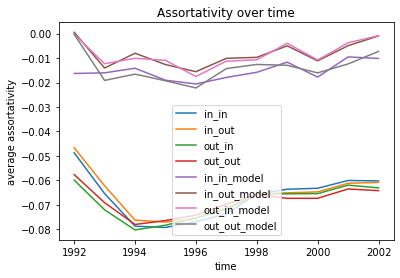

In [35]:
plot_assortativities(data,sorted([key for key in data.keys()]))

1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002


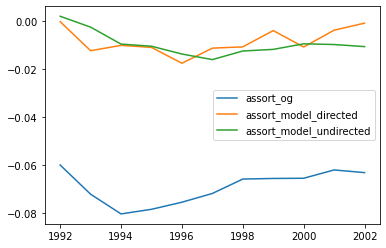

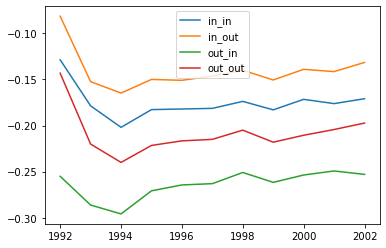

In [27]:
solve02(data, skip_sampling=False)

# A06.3

### Clustering
CWe see a high average clustering coefficient over all the years. It makes sense that local groups like trading with each other. Be it a similar culture or tradition. This reciprocity grew over the years as globalisation increases & trades go beyond local borders.
### Reciprocity
Reciprocity increases over time.

### Assortativity
The strength assortativity is sligthly negativ for our original network. This would imply that there exists high degree nodes with lots of traffic from low degree nodes. However since it is only slightly negativ we cannot definitely conclude this.